<left><img width=100% height=100% src="img/itu_logo.png"></left>

## Lecture 12: Multinomial Regression

### __Gül İnan__<br><br>Istanbul Technical University

## Penguins Dataset

The penguins dataset contains the following columns:

- `Species`: The species of the penguin (Adelie, Gentoo, Chinstrap).
- `Island`: Island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica).
- `Bill Length`: The length in mm of the penguin's bill.
- `Bill Depth`: The depth in mm of the penguin's bill.
- `Flipper Length`: The length in mm of the penguin's flipper.
- `Body Mass`: The body mass of the penguin in grams.
- `Sex`: Penguin sex.
- `Year`: The year when the measurement is done.

<br>
<center><img src="img/penguin.png"/></center>

In [110]:
#https://github.com/mcnakhaee/palmerpenguins
#!pip install palmerpenguins 

In [111]:
#Load the penguins dataset
from palmerpenguins import load_penguins

penguins = load_penguins() #returns a data frame

penguins.head(10) #there are missing values, see below

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female,2007
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male,2007
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,2007
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,2007


In [112]:
penguins.shape

(344, 8)

In [113]:
#Check the species of penguins and their frequencies
penguins.species.value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

We would like to build a `multiclass classifier` to predict the `label of penguins` based on two features `bill_length_mm` and `bill_depth_mm`. 

In [114]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


There are **eleven rows** that contain missing values, which will not be useful in training a classifier since our focus is on multinomial regression today. Let's discard them from the dataset.

In [115]:
#Drop rows containing NaN values
penguins = penguins.dropna(axis=0)

In [116]:
penguins.shape

(333, 8)

## Prepare the data

Just as for binary classification, before training the model, we need to separate the features and label, and then split the data into subsets for training and test. We'll also apply a stratification technique when splitting the data to maintain the proportion of each label value in the training and validation datasets.

In [117]:
# Separate features and labels

penguins_X = penguins[['bill_length_mm', 'bill_depth_mm']]

penguins_y = penguins["species"]

In [118]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
x_penguin_train, x_penguin_test, y_penguin_train, y_penguin_test = train_test_split(penguins_X, penguins_y,    
                                                                                    test_size=0.30,
                                                                                    random_state=0,
                                                                                    stratify=penguins_y)

print ('Training Set Size: %d, Test Set Size: %d \n' % (x_penguin_train.shape[0], x_penguin_test.shape[0]))

Training Set Size: 233, Test Set Size: 100 



Let's explore how the **numerical features** such as `Bill Length` and `Bill Depth` relate to the label by creating some `box plots`.

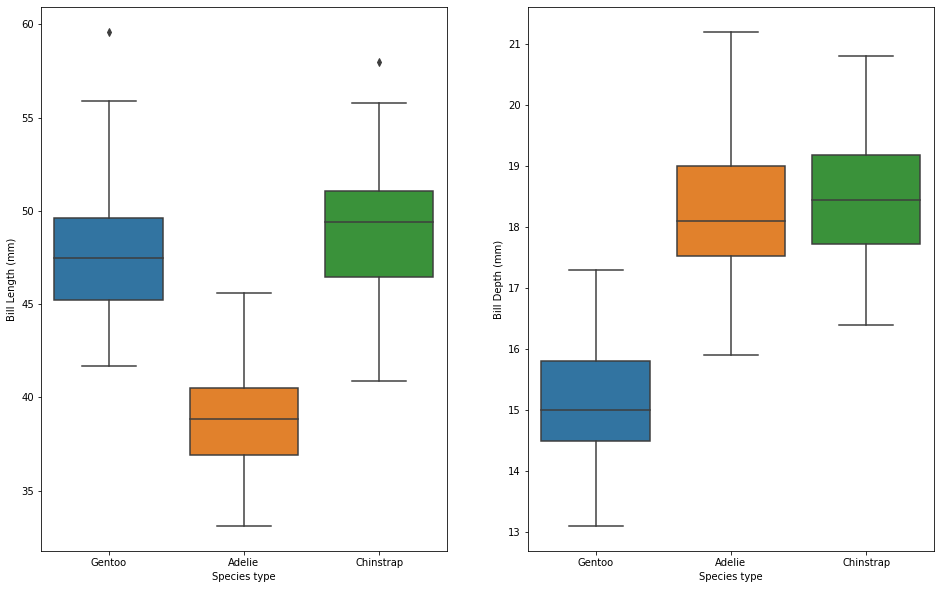

In [119]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 10]

penguin_features = ['bill_length_mm', 'bill_depth_mm'] 

y_label = ['Bill Length (mm)', 'Bill Depth (mm)'] 


for i, feat in enumerate(penguin_features, start=1):
      
    plt.subplot(1,2,i)
    
    g = sns.boxplot(x=y_penguin_train, y=x_penguin_train[feat]) 
    
    g.set_xlabel('Species type')
    
    g.set_ylabel(y_label[(i-1)])
    
plt.show();    

From the box plots, it looks like species Adelie and Chinstrap have similar data profiles for bill depth, but Adelie tend to shorter longer bills. Species Gentoo tends to have clearly differentiated bill depth from the others; which should help us train a good classification model.

## Softmax Function

The `softmax function` can be regarded as a **multiclass** generalization of `logistic function`.  The `softmax function` $
\sigma$ takes a $K$-dimensional input vector $\textbf{z}=(z_1,\ldots,z_k,\ldots,z_K)\in\mathbb{R}^K$, applies the standard exponential function to each component $z_k$, and then normalizes these values by dividing by the sum of all these exponentials.

The `softmax function` $\sigma: \mathbb{R}^K \to (0,1)^K$ is defined as follows: 

$$
\sigma(\textbf{z})=\sigma(z_1, \ldots, z_k, \ldots,z_K)=\Bigg(\frac{\exp(z_1)}{\sum_{l=1}^K \exp(z_l)}, \ldots, \frac{\exp(z_k)}{\sum_{l=1}^K \exp(z_l)},\ldots,
\frac{\exp(z_K)}{\sum_{l=1}^K \exp(z_l)}\Bigg).
$$

This normalization ensures that the sum of the components of the output vector is $\sigma(\textbf{z})$ is $1$.

The `softmax function` is also known as `normalized exponential`.

## Multinomial Regression

For multi-class classification, **given a training dataset** $\mathcal{D} = \{(\mathbf{x}_{1}, y_{1}), (\mathbf{x}_{2}, y_{2}), \ldots, (\mathbf{x}_{n}, y_{n})\}$ of size $n$, the `multinomial regression` builds a functional form between $Pr(y_{i}=k \vert \mathbf{x}_{i})$ 
and the `softmax function` of the `linear predictor`, $z_{k,i}=\boldsymbol{\theta}_k^\top \textbf{x}_i$, which is the linear combination of a set of $d$ features and 
their `class-specific coefficients`, as follows:


\begin{eqnarray}
\begin{split}
Pr(y_{i}=1\vert \mathbf{x}_{i}) &= \sigma(\boldsymbol{\theta}_1^\top \textbf{x}_i)=\frac{\exp(\boldsymbol{\theta}_1^\top \textbf{x}_i)}{\sum_{l=1}^K \exp(\boldsymbol{\theta}_l^\top \textbf{x}_i)}, \\
\vdots \\
Pr(y_{i}=k\vert \mathbf{x}_{i}) &= \sigma(\boldsymbol{\theta}_k^\top \textbf{x}_i)=\frac{\exp(\boldsymbol{\theta}_k^\top \textbf{x}_i)}{\sum_{l=1}^K \exp(\boldsymbol{\theta}_l^\top \textbf{x}_i)}, \\
\vdots \\
Pr(y_{i}=K\vert \mathbf{x}_{i}) &= \sigma(\boldsymbol{\theta}_K^\top \textbf{x}_i)=\frac{\exp(\boldsymbol{\theta}_K^\top \textbf{x}_i)}{\sum_{l=1}^K \exp(\boldsymbol{\theta}_l^\top \textbf{x}_i)}, 
\nonumber
\end{split} 
\end{eqnarray}

where $\sum_{l=1}^{K} Pr(y_{i}=l\vert \mathbf{x}_{i})=1$, $\forall i=1,\ldots,n$.

Its parameter space lies in $\Theta^{K}$, where $\Theta = \mathbb{R}^d$. You may have noticed that this model is slightly over-parametrized.

## Conditional Likelihood

Then, the `conditional likelihood` function of the multinomial regression for a **given training dataset** $\mathcal{D} = \{(\mathbf{x}_{1}, y_{1}), (\mathbf{x}_{2}, y_{2}), \ldots, (\mathbf{x}_{n}, y_{n})\}$ of size $n$ is given by:

\begin{align*}
\mathcal{L}(\boldsymbol{\theta}) & = \prod_{i=1}^n \prod_{k=1}^K I(y_i=k)Pr(y_i=k \mid \mathbf{x}_i) 
\end{align*}

The `log-likelihood` function can be re-written as:


\begin{eqnarray}
\begin{split}
\ell(\boldsymbol{\theta})= \log(\mathcal{L}(\boldsymbol{\theta}))&=\sum_{i=1}^{n} \sum_{k=1}^K I(y_i=k)\log(Pr(y_i=k \mid \mathbf{x}_i))  \\
&= \sum_{i=1}^{n} \sum_{k=1}^K I(y_i=k)\log\Bigg(\frac{\exp(\boldsymbol{\theta}_k^\top \textbf{x}_i)}{\sum_{l=1}^K (\exp(\boldsymbol{\theta}_l^\top \textbf{x}_i)}\Bigg) 
.\nonumber  
\end{split}
\end{eqnarray}

As in the logistic regression, we can use gradient descent to optimize the parameter $\boldsymbol{\theta}$ iteratively.

However, we will apply multinomial regression to the penguins dataset by using `LogisticRegression` from `scikit-learn`.

## How to assign a new observation into one of the classes?

Once we learn $\boldsymbol{\theta}$ from the training dataset $\mathcal{D} = \{(\mathbf{x}_{1}, y_{1}), (\mathbf{x}_{2}, y_{2}), \ldots, (\mathbf{x}_{n}, y_{n})\}$, we can **assign a new observation** $\mathbf{x}_{n+1}$ into one of the classes $\hat{y}_{n+1} \in \{1,\ldots, k, \ldots, K\}$ with the largest probability (`majority voting rule`).


\begin{equation}
k = \underset{(l \in \{1,\ldots,k,\ldots,K \})}{argmax} Pr(\hat{y}_{n+1}=l \vert \mathbf{x}_{n+1}). \nonumber
\end{equation}

## Train and evaluate a multiclass classifier

Now that we have a set of training features and corresponding training labels, we can fit a multiclass classification algorithm to the data to create a model. Most scikit-learn classification algorithms inherently support multiclass classification with `multi_class='multinomial'`. 

In [120]:
from sklearn.linear_model import LogisticRegression

#Train a logistic regression model on the training set
multi_model = LogisticRegression(penalty=None, 
                                 solver='lbfgs', 
                                 multi_class='multinomial')

multi_model.fit(x_penguin_train, y_penguin_train)

print(multi_model)

LogisticRegression(multi_class='multinomial', penalty=None)


In [121]:
#classes learnt by the model
multi_model.classes_

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [122]:
#first line is adelie-specific coefficients, 
#the second line is chinstrap specific coefficients,
#the third line is gentoo-specific coefficients.
print(multi_model.coef_)

[[-1.65958276  3.82668664]
 [ 0.64852489  0.20133075]
 [ 1.01105787 -4.0280174 ]]


In [123]:
print(multi_model.intercept_)

[  5.33513577 -29.33791371  24.00277794]


In [124]:
#estimate the probability of belonging to each class for each element in Xtest
#adelie, chinstrap, gentoo 
print(multi_model.predict_proba(x_penguin_test)[:10])

[[9.99997607e-01 2.39307698e-06 5.75919256e-14]
 [9.99973351e-01 2.64142295e-05 2.35117777e-07]
 [1.83461797e-07 9.98476854e-01 1.52296268e-03]
 [2.33210084e-11 5.14231108e-01 4.85768892e-01]
 [9.98414469e-01 1.58553071e-03 1.31050012e-12]
 [9.99990464e-01 9.53623587e-06 4.79031179e-11]
 [8.36682311e-12 3.42710421e-02 9.65728958e-01]
 [1.22601604e-10 3.59080766e-02 9.64091923e-01]
 [5.87717397e-16 3.24718976e-05 9.99967528e-01]
 [9.99999978e-01 2.21464071e-08 7.65821913e-16]]


Now we can use the trained model to predict the labels for the test features, and compare the predicted labels to the actual labels:

In [125]:
y_penguin_test_pred = multi_model.predict(x_penguin_test)
print('Predicted labels: ', y_penguin_test_pred[:10])

Predicted labels:  ['Adelie' 'Adelie' 'Chinstrap' 'Chinstrap' 'Adelie' 'Adelie' 'Gentoo'
 'Gentoo' 'Gentoo' 'Adelie']


In [126]:
print('Actual labels:', y_penguin_test[:10])

Actual labels: 85        Adelie
44        Adelie
321    Chinstrap
243       Gentoo
19        Adelie
105       Adelie
275       Gentoo
227       Gentoo
180       Gentoo
36        Adelie
Name: species, dtype: object


Now let's look at the confusion matrix for our model: The confusion matrix shows the intersection of predicted and actual label values for each class - in simple terms, the diagonal intersections from top-left to bottom-right indicate the number of correct predictions.

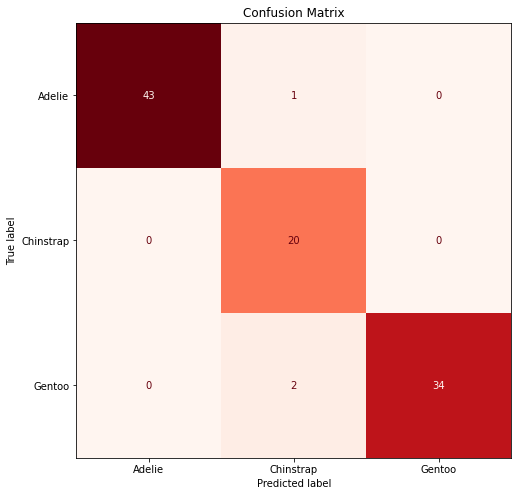

In [127]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams['figure.figsize'] = [16, 8]

cm = ConfusionMatrixDisplay.from_predictions(y_penguin_test, 
                                             y_penguin_test_pred, 
                                             cmap="Reds", 
                                             colorbar=False) 

cm.ax_.set_title("Confusion Matrix");

In [128]:
print("Overall Accuracy:%.2f " % (multi_model.score(x_penguin_test, y_penguin_test)*100)) 

Overall Accuracy:97.00 


In [129]:
from sklearn.metrics import accuracy_score

print("Overall Accuracy:%.2f " % (accuracy_score(y_penguin_test, y_penguin_test_pred)*100))

Overall Accuracy:97.00 


Our multi-class algorithm is able to correctly classify 97% of the test samples.

Let's look at a classification report.

In [130]:
from sklearn.metrics import classification_report

print(classification_report(y_penguin_test, y_penguin_test_pred))

              precision    recall  f1-score   support

      Adelie       1.00      0.98      0.99        44
   Chinstrap       0.87      1.00      0.93        20
      Gentoo       1.00      0.94      0.97        36

    accuracy                           0.97       100
   macro avg       0.96      0.97      0.96       100
weighted avg       0.97      0.97      0.97       100



## Multi-Class Generalizations

As with binary classification, the report includes precision and recall metrics for each class. However, while with binary classification we could focus on the scores for the positive class; in this case, there are multiple classes so we need to look at an overall metric (either the macro or weighted average) to get a sense of how well the model performs across all three classes.

You can get the overall metrics separately from the report using the scikit-learn metrics score classes, but with multiclass results you must specify which average metric you want to use for precision and recall.

In [131]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision: %.2f" % precision_score(y_penguin_test, y_penguin_test_pred, average='macro'))
print("Overall Recall: %.2f" %  recall_score(y_penguin_test, y_penguin_test_pred, average='macro'))

Overall Precision: 0.96
Overall Recall: 0.97


## Decision Boundaries 

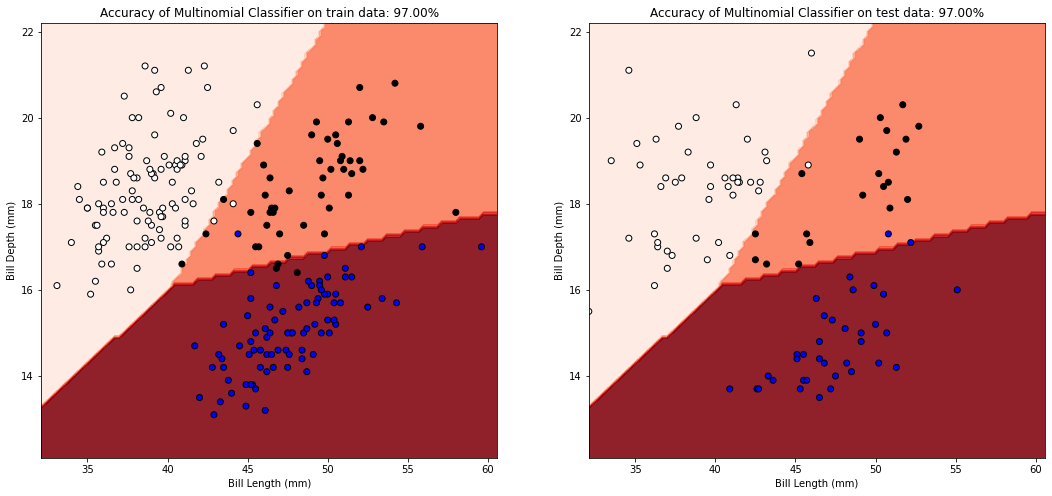

In [132]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]

from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = plt.subplots(1,2)
        
#left plot: plot the training set on the decisionboundary 
db = DecisionBoundaryDisplay.from_estimator(
multi_model, x_penguin_train, 
    response_method="predict", 
    xlabel="Bill Length (mm)", 
    ylabel="Bill Depth (mm)", 
    ax = ax[0], 
    cmap="Reds", 
    alpha=0.9) 

colors = {'Adelie':'white', 'Chinstrap':'black', 'Gentoo':'blue'} 

db.ax_.scatter(x_penguin_train.bill_length_mm, x_penguin_train.bill_depth_mm, c=y_penguin_train.map(colors), edgecolor="black")  
db.ax_.set_title('Accuracy of Multinomial Classifier on train data: %.2f%%' % (multi_model.score(x_penguin_train, y_penguin_train)*100))

#right plot: plot the test data on the decisionboundary 
db = DecisionBoundaryDisplay.from_estimator(
multi_model, x_penguin_train, response_method="predict", xlabel="Bill Length (mm)", ylabel="Bill Depth (mm)", ax = ax[1], cmap="Reds", alpha=0.9) 

db.ax_.scatter(x_penguin_test.bill_length_mm, x_penguin_test.bill_depth_mm, c=y_penguin_test.map(colors), edgecolor="black") 
db.ax_.set_title('Accuracy of Multinomial Classifier on test data: %.2f%%' % (multi_model.score(x_penguin_test, y_penguin_test)*100))

#could not add legend
plt.show();

## References

- https://ubc-cs.github.io/cpsc330/lectures/19_intro_to_computer-vision.html
- https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
- https://peopleanalytics-regression-book.org/multinomial-logistic-regression-for-nominal-category-outcomes.html
- https://learn.microsoft.com/en-us/training/modules/train-evaluate-classification-models/7-exercise-multiclass-classification
- https://www.pycodemates.com/2022/03/multinomial-logistic-regression-definition-math-and-implementation.html
- https://www.mdpi.com/1424-8220/19/10/2307

In [133]:
import session_info
session_info.show()